# A machine learning decision tree approach

The iMeta algorithm is essentially a decision tree algorithm, where the variables and threshold for the decisions at each step are manually specified based on human analysis. The simplest way to apply machine learning techniques to the problem would be to use a similar structure to iMeta, which is a decision tree, but use standard ML training techiniques to learn the parameters such as what thresholds to use and how many branches/leaves to have in the tree for the best results. 

In [1]:
import os
import sys
import pathlib
import functools
import itertools
import datetime

In [2]:
import pandas
import numpy

In [3]:
import matplotlib
import matplotlib.pyplot
import warnings
warnings.filterwarnings('ignore')

In [4]:
font = {'family' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
matplotlib.pyplot.style.use('ggplot')

In [5]:
import ipywidgets
import time

In [6]:
import sklearn
import sklearn.model_selection
import sklearn.preprocessing
import sklearn.tree
import sklearn.metrics

In [7]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [8]:
import xbt.dataset
from xbt.dataset import XbtDataset, UNKNOWN_STR, cat_output_formatter, check_value_found
from xbt.imeta import imeta_classification, XBT_MAX_DEPTH

In [9]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'pangeo'

In [10]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015)
}

In [11]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]

In [12]:
cv_metric_names = ['f1_weighted','precision_weighted','recall_weighted']
input_feature_names = ['country','max_depth', 'year', 'lat', 'lon']
target_feature_name = 'instrument'

In [13]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [14]:
experiment_name = 'nb_single_decisionTree_country'
classifier_class = sklearn.tree.DecisionTreeClassifier
classifier_name = 'decision_tree'
suffix='countryAndLatLon'

In [15]:
classifier_opts = {'max_depth': 20,
                   'min_samples_leaf': 1,
                   'criterion': 'gini'
                  }

In [16]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name, experiment_name)

In [17]:
# create the output for this experiment if it doesn't exist
if not os.path.isdir(xbt_output_dir):
    os.makedirs(xbt_output_dir)
print(f'outputting to {xbt_output_dir}')

outputting to /data/users/shaddad/xbt-data/experiment_outputs/nb_single_decisionTree_country


In [18]:
output_fname_template = 'xbt_output_{exp_name}_{subset}.csv'
result_fname_template = 'xbt_metrics_{classifier}_{suffix}.csv'

In [19]:
%%time
xbt_full_dataset = XbtDataset(xbt_input_dir, year_range)

CPU times: user 51.4 s, sys: 14.6 s, total: 1min 6s
Wall time: 1min 10s


## Data preparation

We are only testing on the labelled data, to be able to evluate performance. The XbtDataset class has filtered out some bad data including profiles with maximum depths less that 0.0 or greater than 2000.0. There were also some profiles with bad date entries, which have been excluded for now.

In [20]:
%%time
xbt_labelled = xbt_full_dataset.filter_obs({'labelled': 'labelled'})

CPU times: user 296 ms, sys: 53.2 ms, total: 349 ms
Wall time: 348 ms


In [21]:
_ = xbt_labelled.get_ml_dataset(return_data = False)

In [22]:
_ = xbt_labelled.filter_features(['instrument','model','manufacturer']).encode_target(return_data = False)

In [23]:
%%time
unseen_cruise_numbers = xbt_labelled.sample_feature_values('cruise_number', fraction=0.1)
validation_var_name = 'validation'
validation_part_name = 'validation_part'
validation_whole_name = 'validation_whole'
validate_indices = list(itertools.chain.from_iterable([list(xbt_labelled.filter_obs({target_feature_name: selected_instrument}).xbt_df.sample(frac=0.1).index) 
for selected_instrument in xbt_labelled['instrument'].unique()]))

CPU times: user 1.6 s, sys: 1.45 ms, total: 1.61 s
Wall time: 1.6 s


In [24]:
xbt_labelled.xbt_df[validation_var_name] = xbt_labelled.xbt_df['cruise_number'].isin(unseen_cruise_numbers)
xbt_labelled.xbt_df[validation_whole_name] = xbt_labelled.xbt_df['cruise_number'].isin(unseen_cruise_numbers)
xbt_labelled.xbt_df.loc[validate_indices, validation_var_name] = True
xbt_labelled.xbt_df[validation_part_name] = False
xbt_labelled.xbt_df.loc[validate_indices, validation_part_name] = True


In [25]:
%%time
xbt_unseen = xbt_labelled.filter_obs({validation_var_name: True})
xbt_working = xbt_labelled.filter_obs({validation_var_name: False})

CPU times: user 101 ms, sys: 2.32 ms, total: 104 ms
Wall time: 101 ms


In [26]:
imeta_classes = xbt_labelled.xbt_df.apply(imeta_classification, axis=1)
imeta_model = imeta_classes.apply(lambda t1: t1[0])
imeta_manufacturer = imeta_classes.apply(lambda t1: t1[1])

In [27]:
imeta_instrument = imeta_classes.apply(lambda t1: f'XBT: {t1[0]} ({t1[1]})') 

We are currently training and evaulating separately for model and manufacturer. We will also need to train and evaulate together as this is ultimately what is wanted (a combined probe model and manufacturer field).

We are using the default 80/20 split in scikit-learn for now. Further work will need to do proper cross validation where several different splits are randomly selected to verify our results are not an artifact of the randomly chosen split.

In [28]:
num_resamples_per_class = 50000


In [29]:
instrument_sample_list = [instrument1 for instrument1, count1 in zip(xbt_labelled.xbt_df[target_feature_name].value_counts().index, xbt_labelled.xbt_df[target_feature_name].value_counts()) if count1 > 100] 


In [30]:
def get_resampled(instrument_list, xbt_subset1, resample_index, random_state):
    resampled_profiles_list = [xbt_subset1.filter_obs({target_feature_name: ins1}).xbt_df.sample(
        num_resamples_per_class, 
        replace=True,
        random_state=random_state,
    ) 
         for ins1 in instrument_list]
    resampled_training_indices = list(set(itertools.chain.from_iterable([list(rp1.index) for rp1 in resampled_profiles_list])))
    if resample_index is None:
        resample_index = 0
    resample_feature_name = f'resample_train_{resample_index}'
    xbt_subset1.xbt_df[resample_feature_name] = xbt_working.xbt_df.index.isin(resampled_training_indices)
    resampled_df = pandas.concat(
        resampled_profiles_list,
        ignore_index=True,
    )
    xbt_resampled_train_all = XbtDataset(xbt_input_dir, year_range, df=resampled_df)
    xbt_resampled_train_all._feature_encoders = xbt_labelled._feature_encoders
    xbt_resampled_train_all._arget_encoders = xbt_labelled._target_encoders
    xbt_resampled_test_all = xbt_working.filter_obs({resample_feature_name: False})
    return (xbt_resampled_train_all, xbt_resampled_test_all)

In [31]:
%%time
xbt_resampled_train_all, xbt_resampled_test_all = get_resampled(
    instrument_sample_list, 
    xbt_working, 
    resample_index=0,
    random_state=int((datetime.datetime.now().timestamp()*1e5) % 1e5),
)

CPU times: user 3.23 s, sys: 105 ms, total: 3.34 s
Wall time: 3.33 s


In [32]:
%%time
xbt_train_all, xbt_test_all = xbt_working.train_test_split(refresh=True, features=[target_feature_name, 'year'])

CPU times: user 1min 43s, sys: 17.9 s, total: 2min
Wall time: 2min


get separate sets of 2 types of unseen data.
* data from cruises where the whole cruise is in the unseen data 
* data where some of the profiles are in the training data

In [33]:
xbt_unseen_whole = xbt_labelled.filter_obs({validation_whole_name: True})
xbt_unseen_part = xbt_labelled.filter_obs({validation_part_name: True})

In [34]:
X_train_all = xbt_train_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_test_all = xbt_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_train_all = xbt_train_all.filter_features([target_feature_name]).get_ml_dataset()[0]
y_instr_test_all = xbt_test_all.filter_features([target_feature_name]).get_ml_dataset()[0]


In [35]:
X_resampled_train_all = xbt_resampled_train_all.filter_features(input_feature_names).get_ml_dataset()[0]
X_resampled_test_all = xbt_resampled_test_all.filter_features(input_feature_names).get_ml_dataset()[0]
y_resampled_instr_train_all = xbt_resampled_train_all.filter_features([target_feature_name]).get_ml_dataset()[0]
y_resampled_instr_test_all = xbt_resampled_test_all.filter_features([target_feature_name]).get_ml_dataset()[0]


In [36]:
X_unseen_all = xbt_unseen.filter_features(input_feature_names).get_ml_dataset()[0]
y_instr_unseen_all = xbt_unseen.filter_features([target_feature_name]).get_ml_dataset()[0]

## Training the classifier

We are using the scikit-learn classifier as the closest analogue to the structure of the iMeta algorithm. This tree can have many more nodes and leaves than iMeta though. it is quick to train and evaluate so it is a useful starting point for setting up the ML processing pipelines, as all the scikit-learn classifiers have a common interface. 

For the model and manufacturer, we train a Decision ree Classifier, then use it to predict values for the train and test sets. We then calculate the accuracy metrics for each for the whole dataset. 

I am using precision, recall and F1 as fairly standard ML metrics of accuracy. Recall is what has been used in the two previous papers (Palmer et. al, Leahy and Llopis et al) so that is the focus. Support is a useful to see what proportion of the profiles in the dataset belong to each of the different classes.

In [37]:
clf_dt_instr1 = classifier_class(**classifier_opts)
clf_dt_instr1.fit(X_train_all,y_instr_train_all)

DecisionTreeClassifier(max_depth=20)

In [38]:
%%time
clf_dict_resampled = {}
for resample_index in range(1,6):
    xbt_resampled_train_all, xbt_resampled_test_all = get_resampled(
        instrument_sample_list, 
        xbt_working, 
        resample_index=resample_index,
        random_state=int((datetime.datetime.now().timestamp()*1e5) % 1e5),
    )
    clf1 = classifier_class(**classifier_opts)
    clf1.fit(xbt_resampled_train_all.filter_features(input_feature_names).get_ml_dataset()[0],
             xbt_resampled_train_all.filter_features([target_feature_name]).get_ml_dataset()[0],
            ) 
    clf_dict_resampled[resample_index] = clf1

CPU times: user 1min 9s, sys: 3.18 s, total: 1min 12s
Wall time: 1min 12s


In [39]:
d1 = {
    f'{target_feature_name}_res_{ix1}': xbt_unseen._feature_encoders[target_feature_name].inverse_transform(clf1.predict(xbt_unseen.filter_features(input_feature_names).get_ml_dataset()[0]))
    for ix1, clf1 in clf_dict_resampled.items()
}
d1['id'] = xbt_unseen['id']
instr_predictions_unseen = pandas.DataFrame(d1)

In [40]:
ens_res_features = [f'{target_feature_name}_res_{ix1}' for ix1, clf1 in clf_dict_resampled.items()]

In [41]:
xbt_unseen.xbt_df = pandas.DataFrame.merge(xbt_unseen.xbt_df, instr_predictions_unseen, on='id')

In [42]:
%%time
calc_disagreements = lambda x: len(set(x))
vote_counts_df = pandas.DataFrame.from_records( 
    {year1: dict(xbt_unseen.filter_obs({'year': year1}).filter_features(ens_res_features).xbt_df.apply(calc_disagreements, axis='columns').value_counts()) for year1 in range(*year_range)},
).transpose().fillna(0.0)
vote_counts_df['year'] = vote_counts_df.index
# vote_counts_df

CPU times: user 2.38 s, sys: 4.81 ms, total: 2.39 s
Wall time: 2.39 s


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


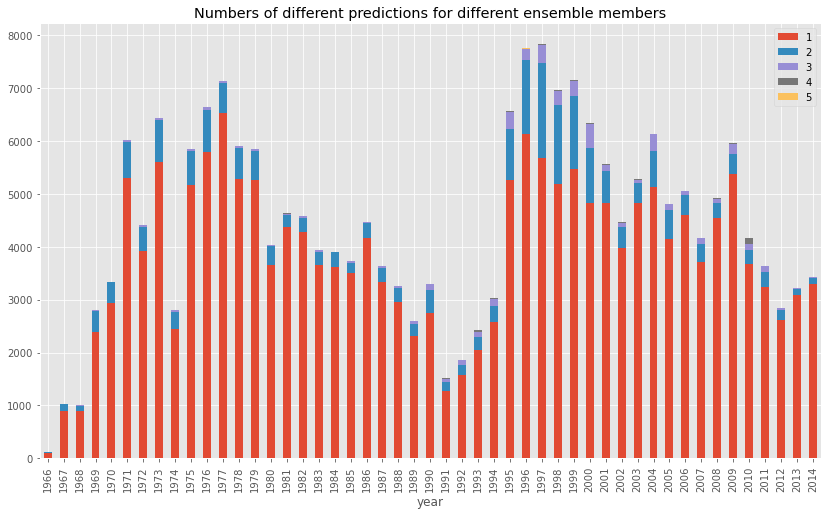

In [43]:
fig1 = matplotlib.pyplot.figure('vote_counts_year', figsize=(14,8))
ax1 = fig1.add_subplot(1,1,1,title='Numbers of different predictions for different ensemble members')
vote_counts_df.plot.bar(
    x='year',
    y=[1,2,3,4,5],
    stacked=True,
    ax=ax1,
)
fig1.savefig('/data/users/shaddad/xbt-data/plots/ensemble_resample_vote_counts.png',
            bbox_inches='tight')

In [45]:
instr_predictions_unseen

,instrument_res_1,instrument_res_2,instrument_res_3,instrument_res_4,instrument_res_5,id
218,XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),2052740
276,XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),2052795
299,XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),2052818
305,XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),2052824
319,XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T4 (SIPPICAN),XBT: T7 (SIPPICAN),XBT: T4 (SIPPICAN),2052838
...,...,...,...,...,...,...
2246752,XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),17526347
2246753,XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),17526348
2246754,XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),17526349
2246755,XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),XBT: DEEP BLUE (SIPPICAN),17526350


In [77]:
probs_unseen_instrument = functools.reduce(lambda x,y: x+y, [xbt_labelled._target_encoders[target_feature_name].transform(instr_predictions_unseen[[pred1]])
for pred1 in instr_predictions_unseen.columns if 'res' in pred1]) / len(instr_predictions_unseen.columns)

In [78]:
probs_unseen_instrument_df = pandas.DataFrame({col_name: probs_unseen_instrument[:,col_ix1]
for col_ix1, col_name in enumerate(xbt_labelled._target_encoders[target_feature_name].categories_[0])})

In [79]:
clf_dt_instr_resampled1 = classifier_class(**classifier_opts)
clf_dt_instr_resampled1.fit(X_resampled_train_all,y_resampled_instr_train_all)

DecisionTreeClassifier(max_depth=20)

In [80]:
metrics_per_class_all = {}
metrics_avg_all = {}
metrics_per_class_all_resampled = {}
metrics_avg_all_resampled = {}

In [81]:
instrument_list = list(xbt_labelled._feature_encoders[target_feature_name].classes_)
instrument_list_resampled = list(xbt_labelled._feature_encoders['instrument'].classes_)

In [82]:
def calc_metric_subset(xbt_subset, clf1, filter_dict, inputs, target_feature, metric_func, metric_args_dict):
    if filter_dict:
        xbt_selected = xbt_subset.filter_obs(filter_dict)
    else:
        xbt_selected = xbt_subset
    if xbt_selected.shape[0] == 0:
        return 0.0
    metrics_result = metric_func(
        clf1.predict(xbt_selected.filter_features(inputs).get_ml_dataset()[0]),
        xbt_selected.filter_features([target_feature]).get_ml_dataset()[0],
        **metric_args_dict)
    return metrics_result                       

In [83]:
do_avg_args_dict = {'labels':list(range(0,len(instrument_list))), 
                    'average':'weighted'}
metrics_defs_dict = {
    'recall': {'metric_func': sklearn.metrics.recall_score, 'metric_args_dict': do_avg_args_dict},
    'precision': {'metric_func': sklearn.metrics.precision_score, 'metric_args_dict': do_avg_args_dict},
    'accuracy': {'metric_func': sklearn.metrics.accuracy_score, 'metric_args_dict': {}},
    'f1': {'metric_func': sklearn.metrics.f1_score, 'metric_args_dict': do_avg_args_dict},
    'balanced_accuracy': {'metric_func': sklearn.metrics.balanced_accuracy_score, 'metric_args_dict': {}},    
}
data_splits = {'train': xbt_train_all,
               'test': xbt_test_all,
               'unseen': xbt_unseen,
               'unseen_part': xbt_unseen_part,
               'unseen_whole': xbt_unseen_whole,               
           }

data_splits_resampled = {'train': xbt_resampled_train_all,
               'test': xbt_resampled_test_all,
               'unseen': xbt_unseen,
               'unseen_part': xbt_unseen_part,
               'unseen_whole': xbt_unseen_whole,               
           }

In [84]:
%%time
metrics_unseen_ens = pandas.DataFrame({ f'{metric_name}_instr_ens': [
    calc_metric_subset(xbt_unseen, 
                       clf1, 
                       None,
                       input_feature_names,
                       target_feature_name,
                       **metric1
                      ) for res_ix1, clf1 in clf_dict_resampled.items()]
 for metric_name,metric1 in metrics_defs_dict.items() 
})
metrics_unseen_ens


CPU times: user 8.25 s, sys: 3.22 s, total: 11.5 s
Wall time: 11.5 s


,recall_instr_ens,precision_instr_ens,accuracy_instr_ens,f1_instr_ens,balanced_accuracy_instr_ens
0,0.908575,0.906669,0.908575,0.903165,0.567081
1,0.913094,0.912398,0.913094,0.908086,0.560663
2,0.910946,0.909474,0.910946,0.905629,0.565089
3,0.909076,0.908151,0.909076,0.902949,0.557176
4,0.907597,0.905624,0.907597,0.902334,0.581417


In [85]:
%%time
metrics_raw_dict = { f'{metric_name}_instr_{split_name}': [calc_metric_subset(split1, 
                   clf_dt_instr1, 
                   {target_feature_name: fn1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  fn1 in instrument_list]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for split_name, split1 in data_splits.items()
}
metrics_raw_dict['num_profiles'] = [xbt_labelled.filter_obs({target_feature_name: fn1}).shape[0] for  fn1 in instrument_list]
metrics_raw_dict[target_feature_name] = [fn1 for  fn1 in instrument_list]

metrics_per_class_df = pandas.DataFrame(metrics_raw_dict)
metrics_per_class_df = metrics_per_class_df.sort_values('num_profiles', ascending=False)

CPU times: user 53.6 s, sys: 2.52 s, total: 56.2 s
Wall time: 56.1 s


In [86]:
%%time
metrics_raw_resampled_dict = { f'{metric_name}_instr_{split_name}': [calc_metric_subset(split1, 
                   clf_dt_instr_resampled1, 
                   {target_feature_name: fn1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  fn1 in instrument_list_resampled]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for split_name, split1 in data_splits_resampled.items()
}
metrics_raw_resampled_dict['num_profiles'] = [xbt_labelled.filter_obs({target_feature_name: fn1}).shape[0] for  fn1 in instrument_list_resampled]
metrics_raw_resampled_dict[target_feature_name] = [fn1 for  fn1 in instrument_list_resampled]

metrics_per_class_resampled_df = pandas.DataFrame(metrics_raw_resampled_dict)
metrics_per_class_resampled_df = metrics_per_class_resampled_df.sort_values('num_profiles', ascending=False)

CPU times: user 1min, sys: 2.4 s, total: 1min 3s
Wall time: 1min 3s


In [87]:
%%time
metrics_annual_raw_dict = { f'{metric_name}_instr_{split_name}': [calc_metric_subset(split1, 
                   clf_dt_instr1, 
                   {'year': year1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  year1 in range(*year_range)]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for split_name, split1 in data_splits.items()
}
metrics_annual_raw_dict['num_profiles'] = [xbt_labelled.filter_obs({'year': year1}).shape[0] for year1 in range(*year_range)]
metrics_annual_raw_dict['year'] = [year1 for  year1 in range(*year_range)]

metrics_annual_df = pandas.DataFrame(metrics_annual_raw_dict)

CPU times: user 1min 29s, sys: 4.15 s, total: 1min 34s
Wall time: 1min 34s


In [88]:
%%time
metrics_annual_raw_resampled_dict = { f'{metric_name}_instr_{split_name}': [calc_metric_subset(split1, 
                   clf_dt_instr_resampled1, 
                   {'year': year1},
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for  year1 in range(*year_range)]
 for metric_name,metric1 in metrics_defs_dict.items() 
 for split_name, split1 in data_splits_resampled.items()
}
metrics_annual_raw_resampled_dict['num_profiles'] = [xbt_labelled.filter_obs({'year': year1}).shape[0] for year1 in range(*year_range)]
metrics_annual_raw_resampled_dict['year'] = [year1 for  year1 in range(*year_range)]

metrics_annual_resampled_df = pandas.DataFrame(metrics_annual_raw_resampled_dict)

CPU times: user 1min 43s, sys: 8.18 s, total: 1min 52s
Wall time: 1min 52s


In [89]:
metrics_all_raw = { f'instr_{metric_name}': [calc_metric_subset(split1, 
                   clf_dt_instr1, 
                   None,
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for split_name, split1 in data_splits.items()]
  
 for metric_name,metric1 in metrics_defs_dict.items()
}
metrics_all_raw['split'] = [split_name for split_name, split1 in data_splits.items()]
metrics_all_df = pandas.DataFrame(metrics_all_raw)

In [90]:
metrics_all_df

,instr_recall,instr_precision,instr_accuracy,instr_f1,instr_balanced_accuracy,split
0,0.972500,0.973732,0.972500,0.972867,0.972956,train
1,0.955270,0.956938,0.955270,0.955878,0.823300,test
2,0.945233,0.946447,0.945233,0.945649,0.777784,unseen
3,0.952136,0.953569,0.952136,0.952647,0.820538,unseen_part
4,0.937711,0.938829,0.937711,0.937997,0.681024,unseen_whole


<AxesSubplot:title={'center':'F1 for all data in splits'}, ylabel='split'>

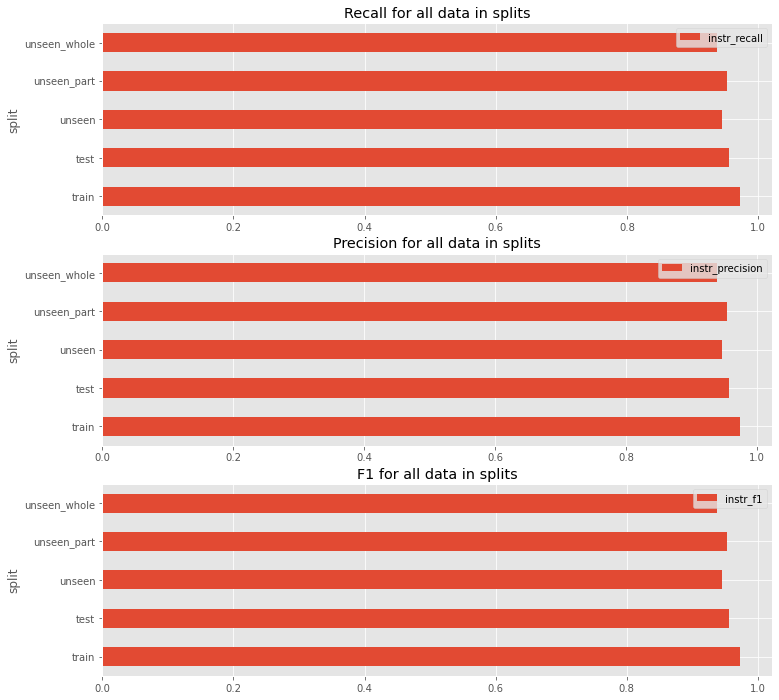

In [123]:
fig1 = matplotlib.pyplot.figure('imbalanced_metrics_all', figsize=(12,12))
ax1 = fig1.add_subplot(3,1,1,title='Recall for all data in splits')
metrics_all_df.plot.barh(x='split', y='instr_recall', ax=ax1)
ax1 = fig1.add_subplot(3,1,2,title='Precision for all data in splits')
metrics_all_df.plot.barh(x='split', y='instr_precision', ax=ax1)
ax1 = fig1.add_subplot(3,1,3,title='F1 for all data in splits')
metrics_all_df.plot.barh(x='split', y='instr_f1', ax=ax1)

In [92]:
%%time
metrics_all_raw_resampled = { f'instr_{metric_name}': [calc_metric_subset(split1, 
                   clf_dt_instr_resampled1, 
                   None,
                   input_feature_names,
                   target_feature_name,
                   **metric1
                  ) for split_name, split1 in data_splits_resampled.items()]
  
 for metric_name,metric1 in metrics_defs_dict.items()
}
metrics_all_raw_resampled['split'] = [split_name for split_name, split1 in data_splits_resampled.items()]
metrics_all_resampled_df = pandas.DataFrame(metrics_all_raw_resampled)

CPU times: user 15.8 s, sys: 7.49 s, total: 23.3 s
Wall time: 23.3 s


In [93]:
metrics_all_df

,instr_recall,instr_precision,instr_accuracy,instr_f1,instr_balanced_accuracy,split
0,0.972500,0.973732,0.972500,0.972867,0.972956,train
1,0.955270,0.956938,0.955270,0.955878,0.823300,test
2,0.945233,0.946447,0.945233,0.945649,0.777784,unseen
3,0.952136,0.953569,0.952136,0.952647,0.820538,unseen_part
4,0.937711,0.938829,0.937711,0.937997,0.681024,unseen_whole


In [94]:
metrics_all_resampled_df

,instr_recall,instr_precision,instr_accuracy,instr_f1,instr_balanced_accuracy,split
0,0.980678,0.980896,0.980678,0.980753,0.980597,train
1,0.925693,0.918591,0.925693,0.913063,0.218212,test
2,0.910095,0.908591,0.910095,0.904762,0.570532,unseen
3,0.918512,0.917979,0.918512,0.913892,0.631331,unseen_part
4,0.901043,0.897509,0.901043,0.894590,0.473407,unseen_whole


## Resampled ensemble results

# Classification result plots

The plots below show the results for the whole XBT dataset. We see that the DT classifier performs well on the training data, but does not seem to generalise well. This especially true, as one would expect, for classes with very little support in the training dataset.

In [95]:
metrics_per_class_df_plot = metrics_per_class_df[[(xbt_unseen.filter_obs({target_feature_name: ins1}).shape[0] >10) for ins1 in metrics_per_class_df['instrument']]]
metrics_per_class_resampled_df_plot = metrics_per_class_resampled_df[[(xbt_unseen.filter_obs({target_feature_name: ins1}).shape[0] >10) for ins1 in metrics_per_class_resampled_df['instrument']]]

In [96]:
table_comparison_classes = pandas.DataFrame({'instrument': metrics_per_class_df['instrument'], 
                  'recall_imbalanced': metrics_per_class_df['recall_instr_unseen'],
                  'recall_resampled': metrics_per_class_resampled_df['recall_instr_unseen'],
                  'precision_imbalanced': metrics_per_class_df['precision_instr_unseen'],
                  'precision_resampled': metrics_per_class_resampled_df['precision_instr_unseen'],
                   'support': [xbt_unseen.filter_obs({target_feature_name: ins1}).shape[0] for ins1 in metrics_per_class_df['instrument']],
                 })
table_comparison_classes.to_csv('/data/users/shaddad/xbt-data/plots/per_class_imablancesVsResampled.csv', index=False)

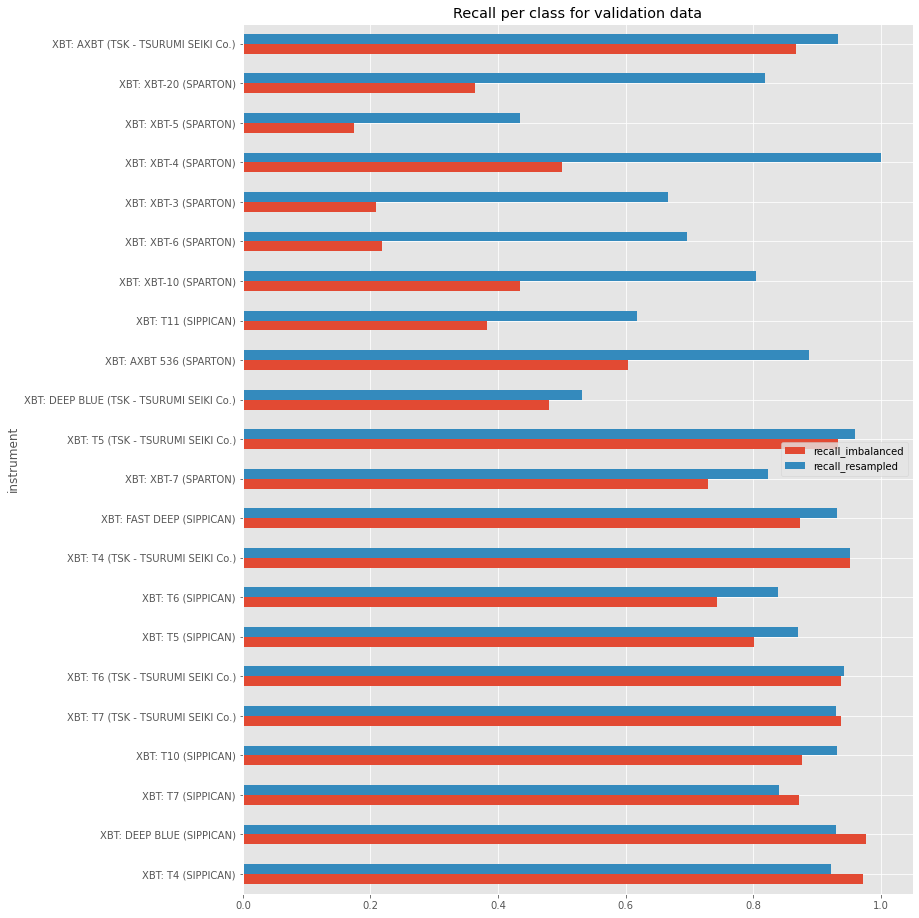

In [114]:
fig1 = matplotlib.pyplot.figure('recall_per_class_unseen', figsize=(12,16))
ax1 = fig1.add_subplot(1,1,1,title='Recall per class for validation data')
_ = pandas.DataFrame({'instrument': metrics_per_class_df_plot['instrument'], 
                  'recall_imbalanced': metrics_per_class_df_plot['recall_instr_unseen'],
                  'recall_resampled': metrics_per_class_resampled_df_plot['recall_instr_unseen'],
                 }).plot.barh(x='instrument', ax=ax1)
fig1.savefig('/data/users/shaddad/xbt-data/plots/recall_unseen_per_class_imbalancedClf.png', bbox_inches='tight')

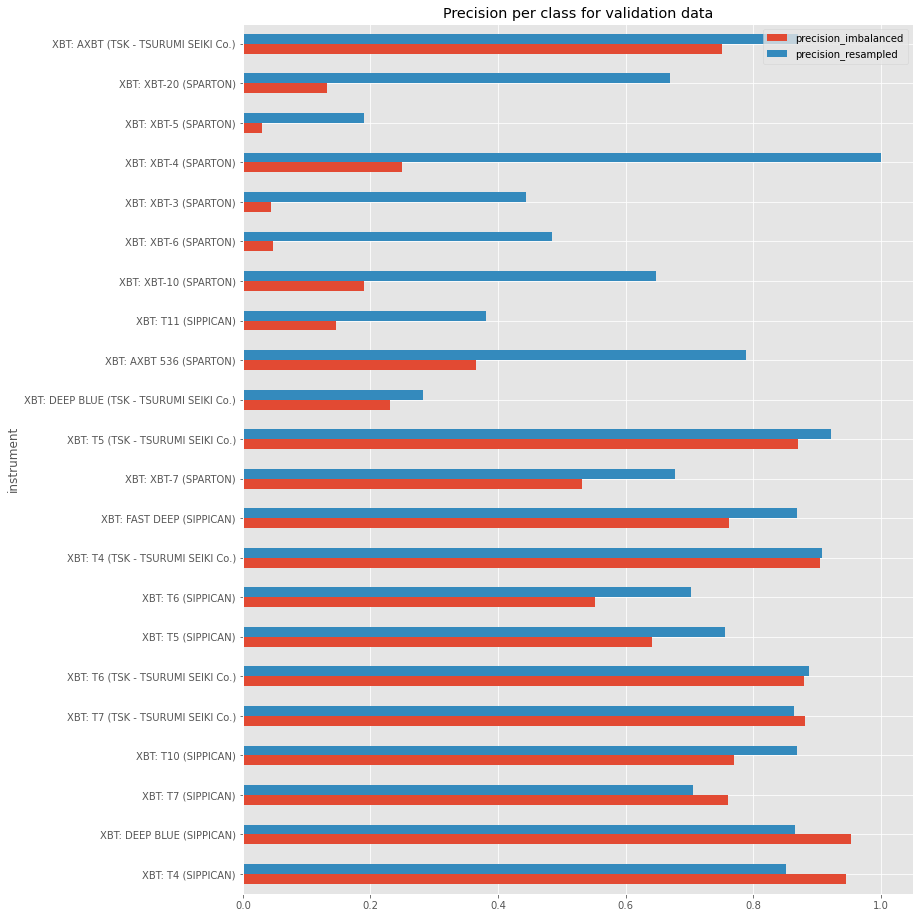

In [115]:
fig1 = matplotlib.pyplot.figure('recall_per_class_unseen', figsize=(12,16))
ax1 = fig1.add_subplot(1,1,1,title='Precision per class for validation data')
_ = pandas.DataFrame({'instrument': metrics_per_class_df_plot['instrument'], 
                  'precision_imbalanced': metrics_per_class_df_plot['precision_instr_unseen'],
                  'precision_resampled': metrics_per_class_resampled_df_plot['precision_instr_unseen'],
                 }).plot.barh(x='instrument', ax=ax1)
fig1.savefig('/data/users/shaddad/xbt-data/plots/precision_unseen_per_class_imbalancedClf.png', bbox_inches='tight')

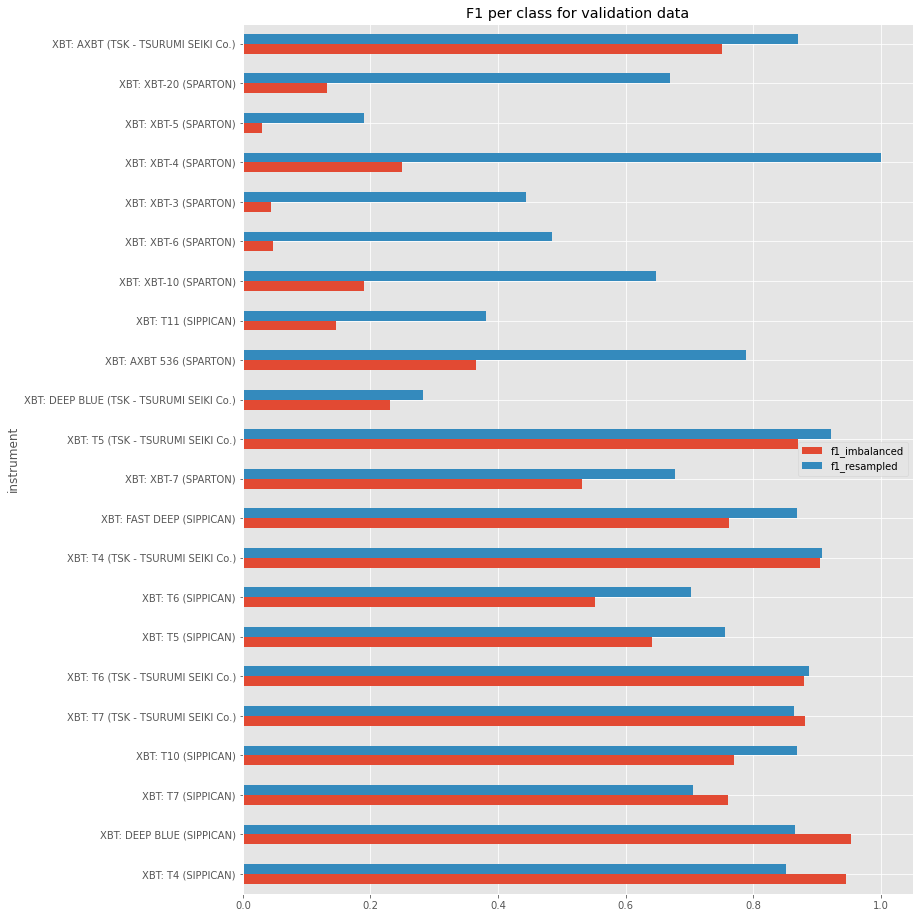

In [116]:
fig1 = matplotlib.pyplot.figure('f1_per_class_unseen', figsize=(12,16))
ax1 = fig1.add_subplot(1,1,1,title='F1 per class for validation data')
_ = pandas.DataFrame({'instrument': metrics_per_class_df_plot['instrument'], 
                  'f1_imbalanced': metrics_per_class_df_plot['precision_instr_unseen'],
                  'f1_resampled': metrics_per_class_resampled_df_plot['precision_instr_unseen'],
                 }).plot.barh(x='instrument', ax=ax1)
fig1.savefig('/data/users/shaddad/xbt-data/plots/f1_unseen_per_class_imbalancedClf.png', bbox_inches='tight')

In [99]:
instr_encoder = xbt_labelled._feature_encoders['instrument']

In [100]:
%%time
imeta_results = []
for year in range(env_date_ranges[environment][0],env_date_ranges[environment][1]):
    y_imeta_instr = instr_encoder.transform(pandas.DataFrame(imeta_instrument[xbt_labelled.xbt_df.year == year]))
    xbt_instr1 = instr_encoder.transform(pandas.DataFrame(xbt_labelled.xbt_df[xbt_labelled.xbt_df.year == year].instrument))
    (im_pr_instr, im_rec_instr, im_f1_instr, im_sup_instr) = sklearn.metrics.precision_recall_fscore_support(xbt_instr1, y_imeta_instr,average='weighted')
    im_acc_instr = sklearn.metrics.accuracy_score(xbt_instr1, y_imeta_instr)
    imeta_results += [{'year': year,
                       'imeta_instr_recall': im_rec_instr,
                       'imeta_instr_precision': im_pr_instr,
                       'imeta_instr_f1': im_f1_instr,
                       'imeta_instr_accuracy': im_acc_instr,
                      }]

CPU times: user 1.23 s, sys: 83.5 ms, total: 1.31 s
Wall time: 1.31 s


In [101]:
imeta_results_df = pandas.DataFrame.from_records(imeta_results)

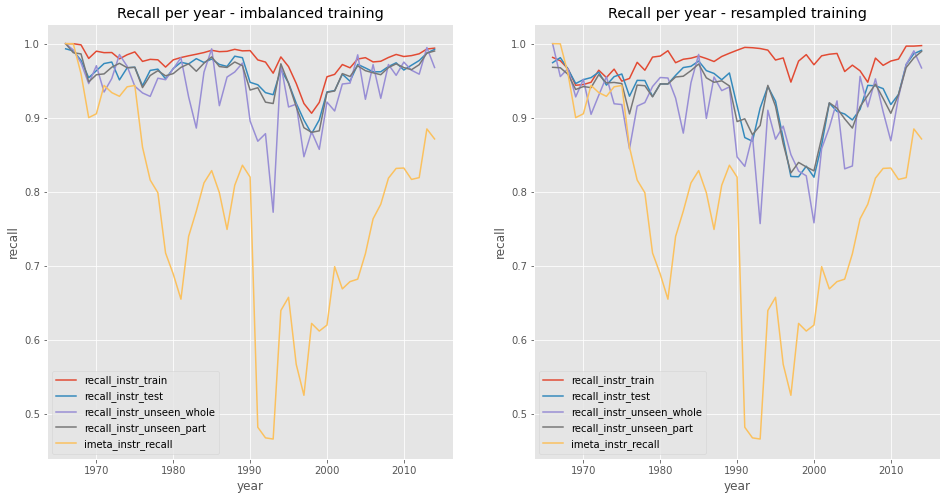

In [102]:
fig1 = matplotlib.pyplot.figure('recall_perYear', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1, title='Recall per year - imbalanced training')
metrics_annual_df.plot.line(x='year', y=['recall_instr_train', 'recall_instr_test', 'recall_instr_unseen_whole', 'recall_instr_unseen_part'], ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_recall', ax=ax1)
ax1.set_ylabel('recall')
ax1 = fig1.add_subplot(1,2,2, title='Recall per year - resampled training')
metrics_annual_resampled_df.plot.line(x='year', y=['recall_instr_train', 'recall_instr_test', 'recall_instr_unseen_whole', 'recall_instr_unseen_part'], ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_recall', ax=ax1)
ax1.set_ylabel('recall')
fig1.savefig('/data/users/shaddad/xbt-data/plots/recall_perYear_imbalancedVsResampled.png', bbox_inches='tight')

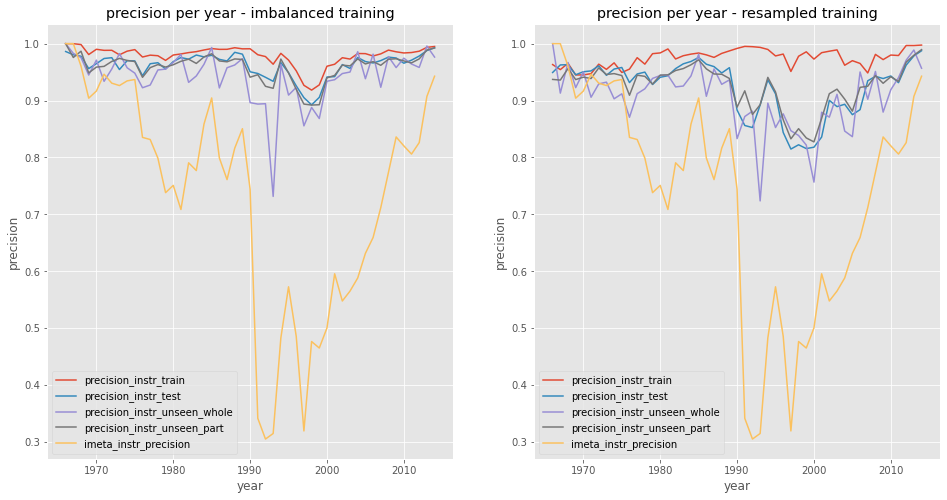

In [103]:
fig1 = matplotlib.pyplot.figure('precision_perYear', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1, title='precision per year - imbalanced training')
metrics_annual_df.plot.line(x='year', y=['precision_instr_train', 'precision_instr_test', 'precision_instr_unseen_whole', 'precision_instr_unseen_part'], ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_precision', ax=ax1)
ax1.set_ylabel('precision')
ax1 = fig1.add_subplot(1,2,2, title='precision per year - resampled training')
metrics_annual_resampled_df.plot.line(x='year', y=['precision_instr_train', 'precision_instr_test', 'precision_instr_unseen_whole', 'precision_instr_unseen_part'], ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_precision', ax=ax1)
ax1.set_ylabel('precision')
fig1.savefig('/data/users/shaddad/xbt-data/plots/precision_perYear_imbalancedVsResampled.png', bbox_inches='tight')

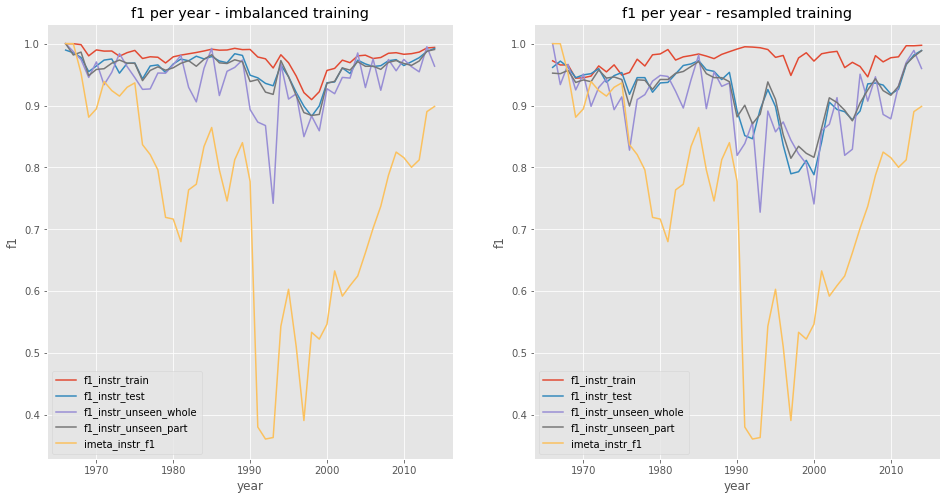

In [121]:
fig1 = matplotlib.pyplot.figure('f1_imbalance_resample_perYear', figsize=(16,8))
ax1 = fig1.add_subplot(1,2,1, title='f1 per year - imbalanced training')
metrics_annual_df.plot.line(x='year', y=['f1_instr_train', 'f1_instr_test', 'f1_instr_unseen_whole', 'f1_instr_unseen_part'], ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_f1', ax=ax1)
ax1.set_ylabel('f1')
ax1 = fig1.add_subplot(1,2,2, title='f1 per year - resampled training')
metrics_annual_resampled_df.plot.line(x='year', y=['f1_instr_train', 'f1_instr_test', 'f1_instr_unseen_whole', 'f1_instr_unseen_part'], ax=ax1)
imeta_results_df.plot.line(x='year', y='imeta_instr_f1', ax=ax1)
ax1.set_ylabel('f1')
fig1.savefig('/data/users/shaddad/xbt-data/plots/f1_perYear_imbalancedVsResampled.png', bbox_inches='tight')

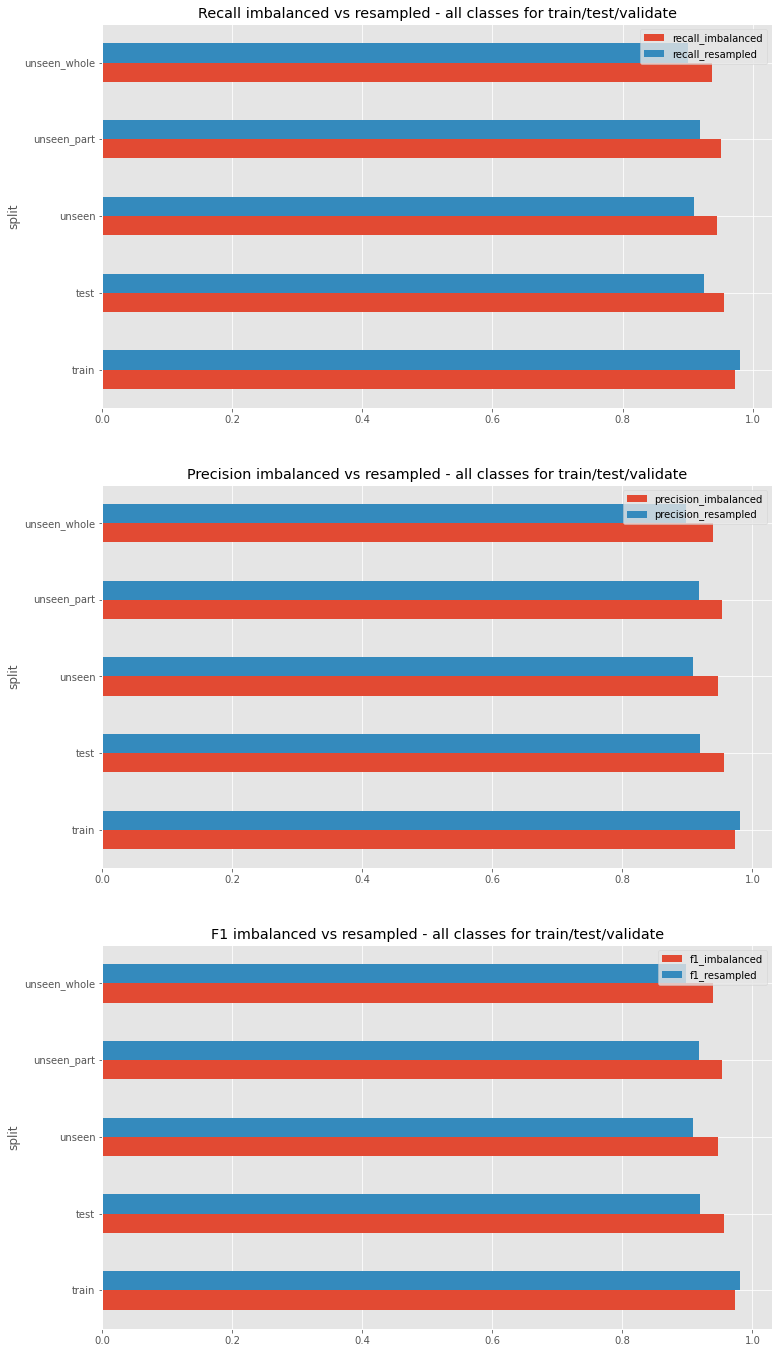

In [118]:
fig1 = matplotlib.pyplot.figure('imbalance_vs_resample_total', figsize=(12,24))
ax1 = fig1.add_subplot(3,1,1, title='Recall imbalanced vs resampled - all classes for train/test/validate')
pandas.DataFrame({
    'split': metrics_all_df['split'],
    'recall_imbalanced':metrics_all_df['instr_recall'],
    'recall_resampled': metrics_all_resampled_df['instr_recall'],
}).plot.barh(x='split', ax=ax1)
ax1 = fig1.add_subplot(3,1,2, title='Precision imbalanced vs resampled - all classes for train/test/validate')
pandas.DataFrame({
    'split': metrics_all_df['split'],
    'precision_imbalanced': metrics_all_df['instr_precision'],
    'precision_resampled': metrics_all_resampled_df['instr_precision'],
}).plot.barh(x='split', ax=ax1)
ax1 = fig1.add_subplot(3,1,3, title='F1 imbalanced vs resampled - all classes for train/test/validate')
pandas.DataFrame({
    'split': metrics_all_df['split'],
    'f1_imbalanced': metrics_all_df['instr_precision'],
    'f1_resampled': metrics_all_resampled_df['instr_precision'],
}).plot.barh(x='split', ax=ax1)
fig1.savefig('/data/users/shaddad/xbt-data/plots/metrics_imbalanced_resampled.png')